In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clv-datasets/NewCleaned_online_retail.csv


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import plotly.express as px
import plotly.graph_objects as go

# Datasets Loading...

In [4]:
df=pd.read_csv('/kaggle/input/clv-datasets/NewCleaned_online_retail.csv')
print(df.head())

  Customer ID Invoice StockCode                          Description  \
0       17850  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1       17850  536365     71053                  WHITE METAL LANTERN   
2       17850  536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3       17850  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4       17850  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

   Quantity InvoiceDate InvoiceTime  InvoiceHour InvoiceDaypart  Price  ...  \
0         6  2010-12-01    08:26:00            8        Morning   2.55  ...   
1         6  2010-12-01    08:26:00            8        Morning   3.39  ...   
2         8  2010-12-01    08:26:00            8        Morning   2.75  ...   
3         6  2010-12-01    08:26:00            8        Morning   3.39  ...   
4         6  2010-12-01    08:26:00            8        Morning   3.39  ...   

  Reason_Category  Non_Sale_Quantity Financial_Impact Customer_Type  \
0      Valid Sale    

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Customer ID             541910 non-null  object 
 1   Invoice                 541910 non-null  object 
 2   StockCode               541910 non-null  object 
 3   Description             541910 non-null  object 
 4   Quantity                541910 non-null  int64  
 5   InvoiceDate             541910 non-null  object 
 6   InvoiceTime             541910 non-null  object 
 7   InvoiceHour             541910 non-null  int64  
 8   InvoiceDaypart          541910 non-null  object 
 9   Price                   541910 non-null  float64
 10  Country                 541910 non-null  object 
 11  TotalAmount             541910 non-null  float64
 12  Category                541910 non-null  object 
 13  Invoice_Type            541910 non-null  object 
 14  Is_Valid_Sale       

# Customer Count Check

In [6]:
print(df['Customer_Type'].value_counts())

Customer_Type
Customer    406830
Guest       135080
Name: count, dtype: int64


# Revenue Contribution by Customer Type

In [8]:
revenue_by_type =df.groupby('Customer_Type')['Revenue'].sum().reset_index()
print(revenue_by_type )


  Customer_Type      Revenue
0      Customer  8731098.943
1         Guest  1495460.230


# Revenue Percentage Contribution

In [9]:
revenue_by_type['Revenue_Percent'] = (
    revenue_by_type['Revenue'] /
    revenue_by_type['Revenue'].sum()
) * 100
print(revenue_by_type)

  Customer_Type      Revenue  Revenue_Percent
0      Customer  8731098.943        85.376702
1         Guest  1495460.230        14.623298


# Visualization: Revenue Share

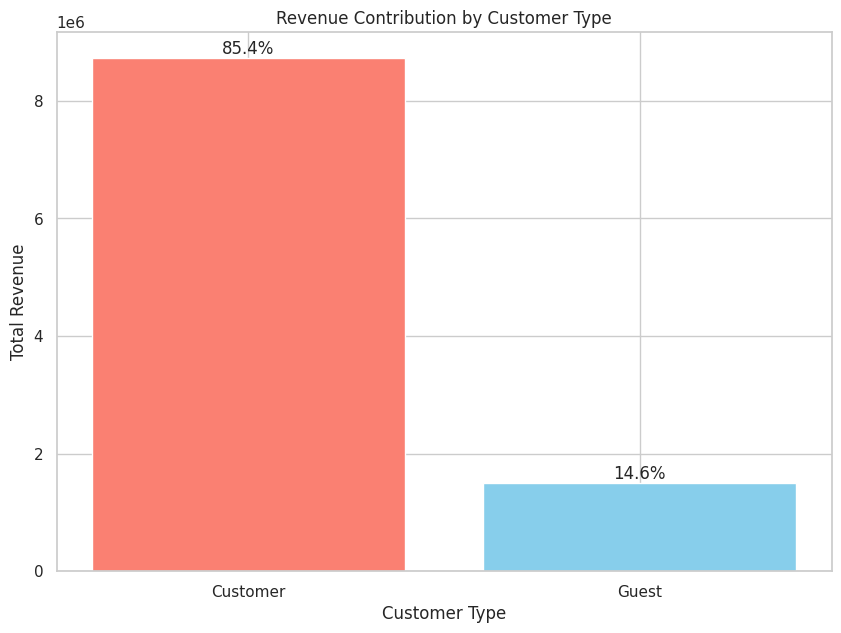

In [15]:
plt.figure(figsize=(10,7))
bars=plt.bar(
    revenue_by_type['Customer_Type'],
    revenue_by_type['Revenue'],color=['salmon','skyblue']
)
for bar, pct in zip(bars, revenue_by_type['Revenue_Percent']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()+5,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )
plt.title('Revenue Contribution by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Revenue')
plt.show()


# Reason Category Breakdown

In [16]:
print(df['Reason_Category'].value_counts())

Reason_Category
Valid Sale                 526578
Return                      10624
Postage / Shipping Fee       1837
Damaged / Missing Item       1603
Fraud / False Order           920
Manual Adjustment             342
Unknown / Miscellaneous         6
Name: count, dtype: int64


# Loss Impact (all non-sale losses for various reasons, positive)

In [19]:
df['Loss_Impact'] = ((df['Is_Valid_Sale'] == 0) & (df['Quantity'] > 0)) * (df['Quantity'] * df['Price']).abs()


# Revenue Reversal (returns)

In [20]:
df['Revenue_Reversal'] = ((df['Is_Valid_Sale'] == 0) & (df['Quantity'] < 0)) * (df['Quantity'] * df['Price'])

# Loss summery

In [26]:
loss_summary = df.groupby('Reason_Category')['Loss_Impact'].sum().reset_index().head(4)
print(loss_summary)

          Reason_Category  Loss_Impact
0  Damaged / Missing Item    38075.950
1     Fraud / False Order     3472.690
2       Manual Adjustment    92038.911
3  Postage / Shipping Fee   284431.700


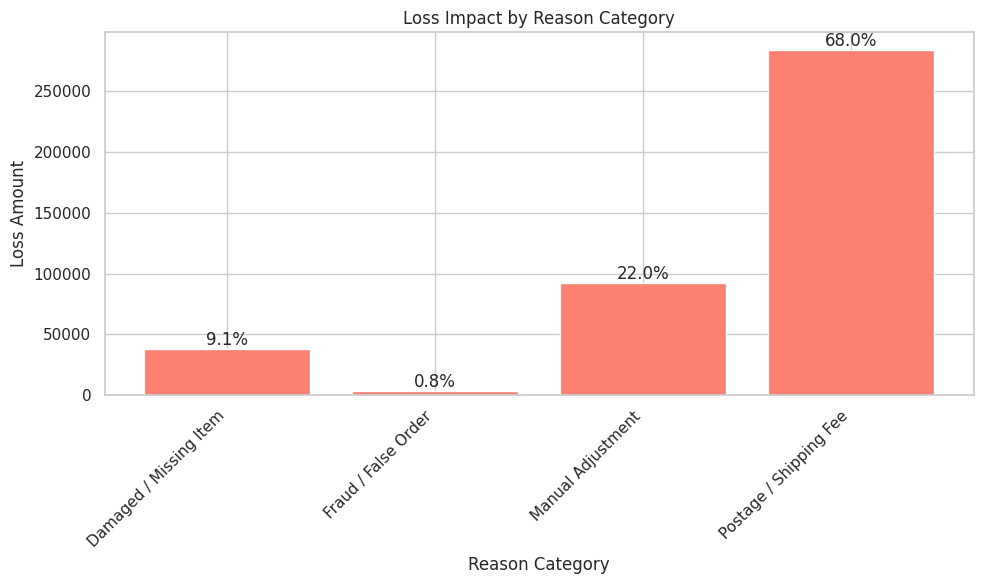

In [27]:
plt.figure(figsize=(10,6))
bars = plt.bar(loss_summary['Reason_Category'], loss_summary['Loss_Impact'], color='salmon')
total_loss = loss_summary['Loss_Impact'].sum()

for bar, pct in zip(bars, (loss_summary['Loss_Impact'] / total_loss) * 100):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )

plt.title('Loss Impact by Reason Category')
plt.xlabel('Reason Category')
plt.ylabel('Loss Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Creating new dataframe to do CLV

In [28]:
df_clv = df[
    (df['Customer_Type'] == 'Customer') &
    (df['Is_Valid_Sale'] == 1) &
    (df['Is_Positive_Quantity'] == 1) &
    (df['Invoice_Type'] == 'Sale')
].copy()
print(df_clv.head())

  Customer ID Invoice StockCode                          Description  \
0       17850  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1       17850  536365     71053                  WHITE METAL LANTERN   
2       17850  536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3       17850  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4       17850  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

   Quantity InvoiceDate InvoiceTime  InvoiceHour InvoiceDaypart  Price  ...  \
0         6  2010-12-01    08:26:00            8        Morning   2.55  ...   
1         6  2010-12-01    08:26:00            8        Morning   3.39  ...   
2         8  2010-12-01    08:26:00            8        Morning   2.75  ...   
3         6  2010-12-01    08:26:00            8        Morning   3.39  ...   
4         6  2010-12-01    08:26:00            8        Morning   3.39  ...   

  Financial_Impact  Customer_Type Customer_Invoice_Count  \
0              0.0       Custome

# checking rows from the actual dataframe has minimized or not?

In [32]:
print(df_clv.shape)
print(df_clv['Customer ID'].nunique())

(395158, 29)
4335


# Creating RFM dataframe

In [33]:
rfm_cols = df_clv[[
    'Customer ID',
    'Customer_Invoice_Count',
    'Monetary_Value',
    'Recency_Days'
]].drop_duplicates()
print(rfm_cols.head())

   Customer ID  Customer_Invoice_Count  Monetary_Value  Recency_Days
0        17850                      34      158.565000           372
9        13047                       9      359.176667            56
26       12583                      15      447.025333             2
46       13748                       5      189.650000            95
65       15100                       3      292.000000           333


# Recency Distribution

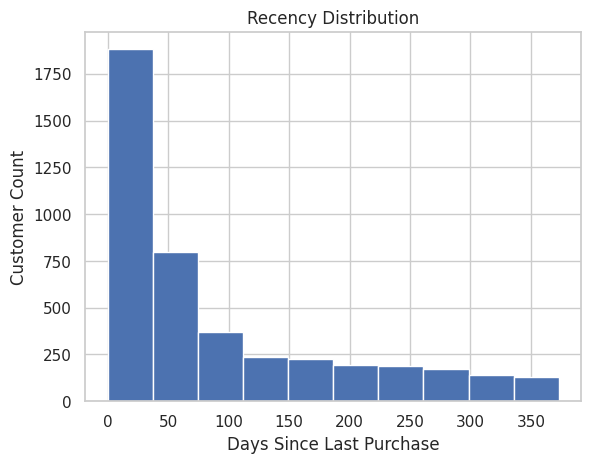

In [34]:
plt.figure()
plt.hist(rfm_cols['Recency_Days'])
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Customer Count')
plt.show()


# Frequency Distribution

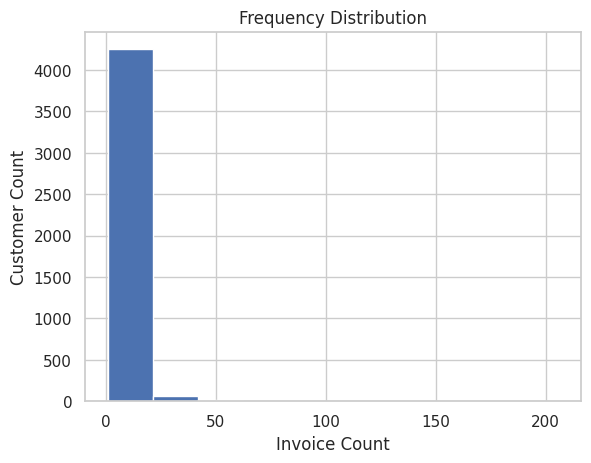

In [35]:
plt.figure()
plt.hist(rfm_cols['Customer_Invoice_Count'])
plt.title('Frequency Distribution')
plt.xlabel('Invoice Count')
plt.ylabel('Customer Count')
plt.show()


# Monetary Distribution

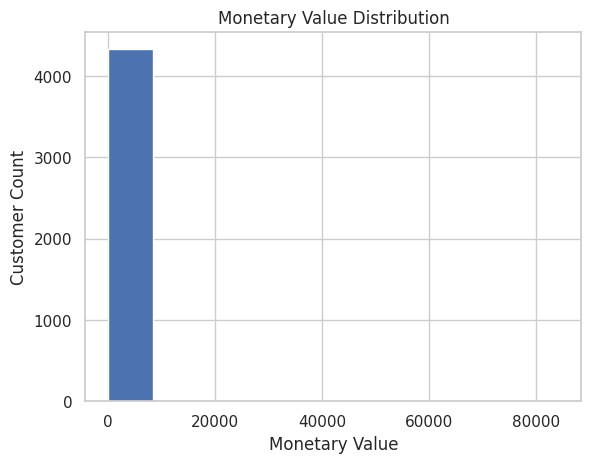

In [36]:
plt.figure()
plt.hist(rfm_cols['Monetary_Value'])
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Customer Count')
plt.show()
